# Classification d’images de fleurs pour reconnaissance automatisée

## 1. Division des données en train, validation, et test

In [4]:
import os
import shutil
import numpy as np

# Chemin du dossier principal contenant les classes
base_dir = '/Users/cisse/Documents/Master 2/Deep Learning/flowers'  # Chemin où se trouvent les dossiers 'daisy', 'dandelion', etc.
train_dir = './data/train'
val_dir = './data/validation'
test_dir = './data/test'

# Création des dossiers train/validation/test
for folder in [train_dir, val_dir, test_dir]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Répartition des données pour chaque classe
classes = [cls for cls in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, cls))]  # Filtrer uniquement les dossiers
for class_name in classes:
    class_path = os.path.join(base_dir, class_name)  # Chemin du dossier de la classe
    images = os.listdir(class_path)  # Liste des images
    np.random.shuffle(images)  # Mélanger les images
    
    # Détermine les splits
    train_split = int(0.7 * len(images))  # 70% pour train
    val_split = int(0.9 * len(images))   # 20% pour validation, 10% pour test
    
    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]
    
    # Copie les images dans les dossiers correspondants
    for img_set, dest_dir in zip([train_images, val_images, test_images], 
                                 [train_dir, val_dir, test_dir]):
        dest_folder = os.path.join(dest_dir, class_name)
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)
        for img in img_set:
            shutil.copy(os.path.join(class_path, img), os.path.join(dest_folder, img))

print("Données réparties dans train, validation, et test.")

Données réparties dans train, validation, et test.


## 2. Prépararation des générateurs de données avec augmentation

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Générateur de données avec augmentation
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Génére les données
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150, 150), 
                                                    batch_size=32, 
                                                    class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, 
                                                target_size=(150, 150), 
                                                batch_size=32, 
                                                class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=32, 
                                                  class_mode='categorical')

Found 3019 images belonging to 5 classes.
Found 863 images belonging to 5 classes.
Found 435 images belonging to 5 classes.


## 3. Construire et entraîner un CNN basique

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Définir un CNN basique avec `Input`
cnn_model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 classes : daisy, dandelion, rose, sunflower, tulip
])

# Compilation
cnn_model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# Entraînement
history = cnn_model.fit(train_generator, 
                        epochs=10, 
                        validation_data=val_generator)

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 181ms/step - accuracy: 0.2930 - loss: 1.6841 - val_accuracy: 0.4936 - val_loss: 1.2109
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - accuracy: 0.4639 - loss: 1.2330 - val_accuracy: 0.5017 - val_loss: 1.1790
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 0.4902 - loss: 1.1827 - val_accuracy: 0.5562 - val_loss: 1.1041
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 0.5545 - loss: 1.0617 - val_accuracy: 0.6211 - val_loss: 0.9701
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 200ms/step - accuracy: 0.6000 - loss: 1.0023 - val_accuracy: 0.6524 - val_loss: 0.8995
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.6217 - loss: 0.9722 - val_accuracy: 0.6454 - val_loss: 0.9255
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.6567 - loss: 0.9013 - val_accuracy: 0.6837 - val_loss: 0.8346
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 204ms/step - accuracy: 0.6776 - loss: 0.8292 - val_accu

le modèle CNN montre une progression notable au fil des époques, mais il semble plafonner autour d’une précision
d’entraînement de 65% et d’une précision de validation de 71%.

## 4. modèle pré-entraîné (ResNet50)

In [17]:
from tensorflow.keras.applications import ResNet50

# Charge un modèle pré-entraîné
pretrained_model = ResNet50(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Congélation des couches du modèle
for layer in pretrained_model.layers:
    layer.trainable = False

# Ajout d'une tête de classification
model = Sequential([
    pretrained_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compilation
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Entraînement
history_pretrained = model.fit(train_generator, 
                               epochs=10, 
                               validation_data=val_generator)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step
Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 50s 506ms/step - accuracy: 0.1902 - loss: 2.1539 - val_accuracy: 0.2433 - val_loss: 1.6064
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 48s 508ms/step - accuracy: 0.2316 - loss: 1.6085 - val_accuracy: 0.2433 - val_loss: 1.6035
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 517ms/step - accuracy: 0.2316 - loss: 1.6040 - val_accuracy: 0.2433 - val_loss: 1.6016
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 518ms/step - accuracy: 0.2381 - loss: 1.6031 - val_accuracy: 0.2433 - val_loss: 1.6003
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 50s 522ms/step - accuracy: 0.2418 - loss: 1.5980 - val_accuracy: 0.2433 - val_loss: 1.5995
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 518ms/step - accuracy: 0.2283 - loss: 1.6042 - val_accuracy: 0.2433 - val_loss: 1.5991
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 50s 523ms/step - accuracy: 0.2359 - loss: 1.6046 - val_accuracy: 0.2433 - val_loss: 1.5988
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 50s 525

Les résultats montrent que la précision du modèle stagne à environ 24%, ce qui est exactement la même précision que celle du modèle de base. Cela signifie que le modèle pré-entraîné ResNet50 ne parvient pas à apprendre efficacement pour mon problème actuel.

## Comment resourdre le problème ?

Tout d'abord je comment par augmenter mes données ensuite je dé-gele les 10 dernière couches par la méthodes de Fine-tuning , je réduis mon learning rate et j'augmente mon nombre epochs.

In [50]:
# Augmentation des données
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')

# Charge le modèle pré-entraîné
pretrained_model = ResNet50(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Dé-gele les 10 dernières couches (Fine-tuning des couches supérieures)
for layer in pretrained_model.layers[-10:]:
    layer.trainable = True

# Ajout de la tête de classification
model = Sequential([
    pretrained_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compilation avec un learning rate réduit
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Found 3019 images belonging to 5 classes.
Found 863 images belonging to 5 classes.
Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.3133 - loss: 2.5125 - val_accuracy: 0.2723 - val_loss: 1.7777
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.5186 - loss: 1.3228 - val_accuracy: 0.1958 - val_loss: 1.8900
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.6189 - loss: 1.0388 - val_accuracy: 0.1727 - val_loss: 2.1778
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.6744 - loss: 0.8534 - val_accuracy: 0.2039 - val_loss: 1.8357
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.7124 - loss: 0.7605 - val_accuracy: 0.2851 - val_loss: 1.6121
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.7292 - loss: 0.7395 - val_accuracy: 0.4056 - val_loss: 1.4218
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.7683 - loss: 0.6246 - val_accuracy: 0.4948 - val_loss: 1.1858
Epoch 8/20
95/95 ━━━━━━━━━━━

Le modèle montre une excellente amélioration dans l’entraînement. 

- Précision d’entraînement **(88.83%)** : Cela montre que le modèle a bien appris à distinguer les caractéristiques des différentes classes dans le jeu d’entraînement.
  
- Précision de validation **(89.57%)** : Une précision de validation légèrement supérieure à celle de l’entraînement indique une bonne généralisation du modèle.
  
- Perte d’entraînement et de validation : Les valeurs de perte (loss) pour l’entraînement et la validation sont très proches, ce qui suggère que le modèle n’est pas surentraîné.

## Évaluation sur le jeu de test

In [51]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Précision sur le jeu de test : {test_accuracy * 100:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 424ms/step - accuracy: 0.8717 - loss: 0.3716
Précision sur le jeu de test : 88.51%


Le modèle atteint une excellente précision sur le jeu de test, avec **88,51%** de précision et une perte relativement faible (0.3716). Cela indique que le modèle a bien généralisé sur des données non vues.

## Visualisation des courbes d’entraînement 

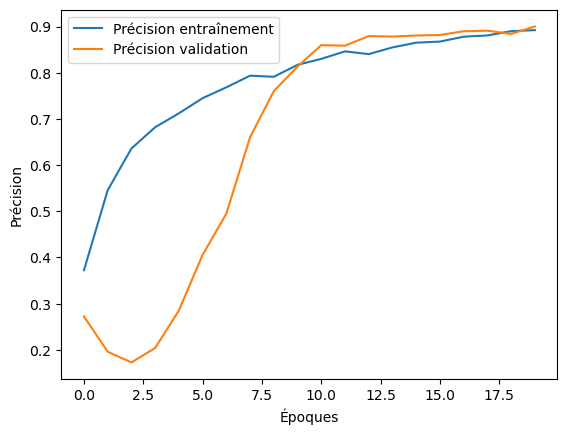

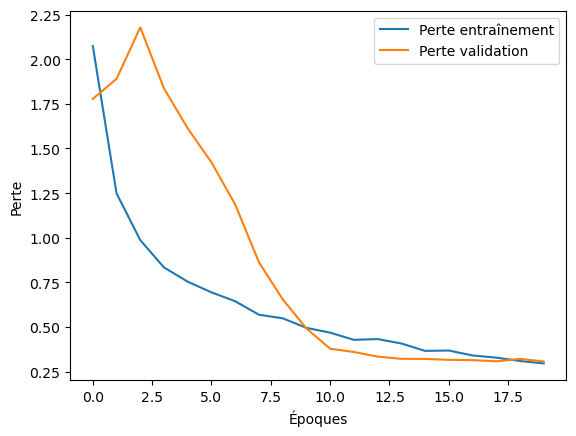

In [64]:
import matplotlib.pyplot as plt

# Courbes de précision
plt.plot(history.history['accuracy'], label='Précision entraînement')
plt.plot(history.history['val_accuracy'], label='Précision validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.show()

# Courbes de perte
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()

**Précision (Graphique supérieur)** :
- La précision d’entraînement augmente régulièrement jusqu’à environ **90%**, ce qui montre que le modèle apprend correctement.
- La précision de validation suit une tendance similaire, atteignant également **~89%**.
- Les courbes se rapprochent vers la fin, suggérant que le modèle généralise bien sans overfitting.
  
**Perte (Graphique inférieur)** :
- La perte d’entraînement diminue régulièrement, indiquant que le modèle s’améliore sur les données d’entraînement.
- La perte de validation diminue également de manière similaire, sans signe de divergence, ce qui montre que le modèle ne surapprend pas.
- Les pertes (entraînement et validation) convergent, ce qui est un bon signe de généralisation.

**Conclusion**

- Pas de surapprentissage évident : Les courbes de précision et de perte d’entraînement et de validation
sont proches,ce qui signifie que le modèle ne surapprend pas aux données d’entraînement.
  
- Convergence efficace : Les deux pertes convergent vers des valeurs similaires, indiquant un bon équilibre entre
apprentissage et généralisation.

## Analyse des erreurs 

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 350ms/step


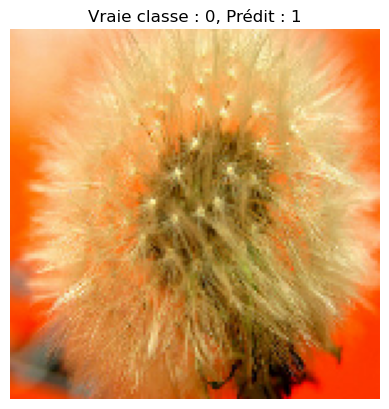

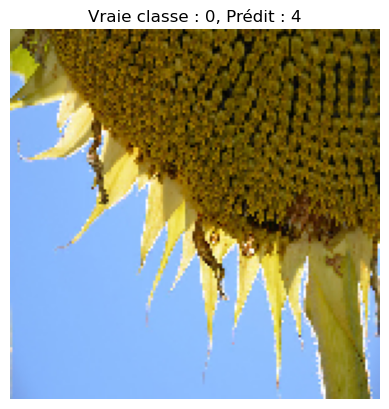

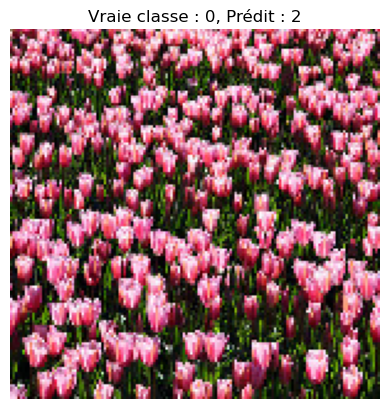

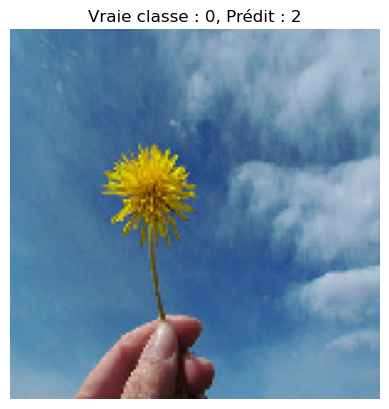

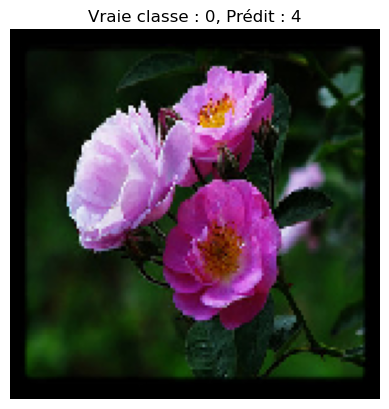

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Prédictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Trouver les indices des erreurs
misclassified_indices = np.where(y_pred != y_true)[0]

# Afficher quelques erreurs
for i in range(min(5, len(misclassified_indices))):  # Affiche 5 erreurs max
    img, label_true = test_generator[misclassified_indices[i]][0], y_true[misclassified_indices[i]]
    label_pred = y_pred[misclassified_indices[i]]

    plt.imshow(img[0])  # Afficher l'image
    plt.title(f"Vraie classe : {label_true}, Prédit : {label_pred}")
    plt.axis('off')
    plt.show()

 ## Génération de la matrice de confusion

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step
Matrice de confusion :
 [[15 18 15 12 17]
 [23 30 18 16 19]
 [11 19 15 16 18]
 [13 19 12 11 19]
 [16 21 18 19 25]]
Rapport de classification :
               precision    recall  f1-score   support

       daisy       0.19      0.19      0.19        77
   dandelion       0.28      0.28      0.28       106
        rose       0.19      0.19      0.19        79
   sunflower       0.15      0.15      0.15        74
       tulip       0.26      0.25      0.25        99

    accuracy                           0.22       435
   macro avg       0.21      0.21      0.21       435
weighted avg       0.22      0.22      0.22       435



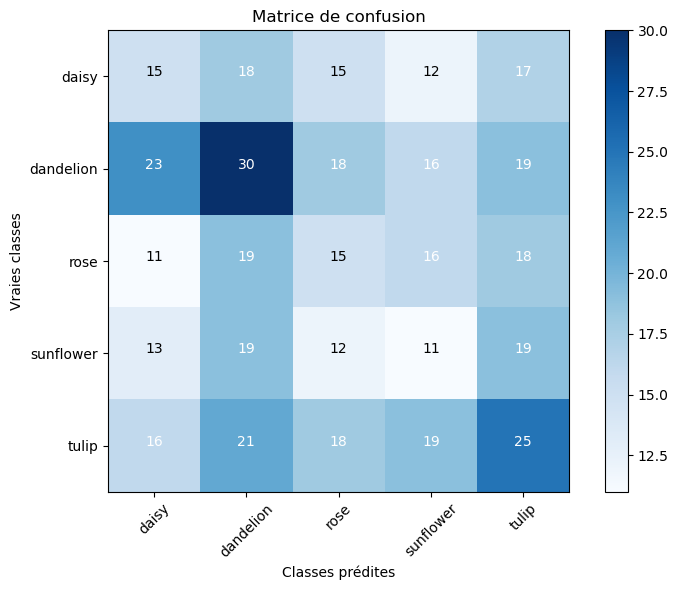

In [70]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Prédictions sur le jeu de test
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)  # Classes prédites
y_true = test_generator.classes      # Classes réelles

# Matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)
print("Matrice de confusion :\n", conf_matrix)

# Rapport de classification
print("Rapport de classification :\n", classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Affichage de la matrice de confusion sous forme graphique
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Vraies classes')
    plt.xlabel('Classes prédites')
    plt.tight_layout()

# Afficher la matrice de confusion
class_names = list(test_generator.class_indices.keys())
plot_confusion_matrix(conf_matrix, class_names)

In [61]:
model.save('resnet50_fine_tuned.keras')

La matrice de confusion et rapport de classification montrent que le modèle a encore des difficultés à classer correctement les images.
Par exemple, pour daisy, il y a beaucoup de confusion avec d’autres classes (seulement 15 correctement classées sur 77).
La précision et le rappel sont faibles pour toutes les classes (entre 15% et 28%).
L’exactitude globale est de 22%, ce qui est loin de l’attendu pour un modèle bien entraîné.

Pour ameliorer le modèle encore plus : 
- nous pouvons appliquer des **poids de classe ou reequilibrer les données**
- **Augmenter les époques d'entrainement de plus de 20**
- **Tester une taille d'image plus grande** et une augmentation des données

## 6. Test sur des images externes

In [74]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Charge une image externe
img_path = '/Users/cisse/Downloads/sessile-sessile-roses-a-la-tige-2-1000x1000.jpg.webp'  # Chemin de l'image
img = image.load_img(img_path, target_size=(150, 150))  # Redimensionner l'image
img_array = image.img_to_array(img) / 255.0  # Normaliser les pixels (entre 0 et 1)
img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour la batch_size

# Prédire la classe
prediction = model.predict(img_array)
predicted_class_idx = np.argmax(prediction, axis=1)[0]  # Index de la classe prédite

# Obtenir le nom de la classe prédite
class_indices = test_generator.class_indices  # Correspondance entre noms de classes et indices
class_names = list(class_indices.keys())
predicted_class_name = class_names[predicted_class_idx]

# Résultat
print(f"Classe prédite (indice) : {predicted_class_idx}")
print(f"Classe prédite (nom) : {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
Classe prédite (indice) : 2
Classe prédite (nom) : rose


In [80]:
# Charge une image externe
img_path = '/Users/cisse/Downloads/flower-198213_1280.jpg'  # Chemin de l'image
img = image.load_img(img_path, target_size=(150, 150))  # Redimensionner l'image
img_array = image.img_to_array(img) / 255.0  # Normaliser les pixels (entre 0 et 1)
img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour la batch_size

# Prédire la classe
prediction = model.predict(img_array)
predicted_class_idx = np.argmax(prediction, axis=1)[0]  # Index de la classe prédite

# Obtenir le nom de la classe prédite
class_indices = test_generator.class_indices  # Correspondance entre noms de classes et indices
class_names = list(class_indices.keys())
predicted_class_name = class_names[predicted_class_idx]

# Résultat
print(f"Classe prédite (indice) : {predicted_class_idx}")
print(f"Classe prédite (nom) : {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Classe prédite (indice) : 0
Classe prédite (nom) : daisy


In [84]:
# Charge une image externe
img_path = '/Users/cisse/Downloads/thumb_43.jpg'  # Chemin de l'image
img = image.load_img(img_path, target_size=(150, 150))  # Redimensionner l'image
img_array = image.img_to_array(img) / 255.0  # Normaliser les pixels (entre 0 et 1)
img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour la batch_size

# Prédire la classe
prediction = model.predict(img_array)
predicted_class_idx = np.argmax(prediction, axis=1)[0]  # Index de la classe prédite

# Obtenir le nom de la classe prédite
class_indices = test_generator.class_indices  # Correspondance entre noms de classes et indices
class_names = list(class_indices.keys())
predicted_class_name = class_names[predicted_class_idx]

# Résultat
print(f"Classe prédite (indice) : {predicted_class_idx}")
print(f"Classe prédite (nom) : {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Classe prédite (indice) : 1
Classe prédite (nom) : dandelion


In [119]:
# Charge une image externe
img_path = '/Users/cisse/Downloads/TULIPE2.jpg'  # Chemin de l'image
img = image.load_img(img_path, target_size=(150, 150))  # Redimensionner l'image
img_array = image.img_to_array(img) / 255.0  # Normaliser les pixels (entre 0 et 1)
img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour la batch_size

# Prédire la classe
prediction = model.predict(img_array)
predicted_class_idx = np.argmax(prediction, axis=1)[0]  # Index de la classe prédite

# Obtenir le nom de la classe prédite
class_indices = test_generator.class_indices  # Correspondance entre noms de classes et indices
class_names = list(class_indices.keys())
predicted_class_name = class_names[predicted_class_idx]

# Résultat
print(f"Classe prédite (indice) : {predicted_class_idx}")
print(f"Classe prédite (nom) : {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Classe prédite (indice) : 4
Classe prédite (nom) : tulip


In [123]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Charge une image externe
img_path = '/Users/cisse/Downloads/6f18aea148f2b1b55498857150bfc426.jpg'  # Chemin de l'image
img = image.load_img(img_path, target_size=(150, 150))  # Redimensionner l'image
img_array = image.img_to_array(img) / 255.0  # Normaliser les pixels (entre 0 et 1)
img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour la batch_size

# Prédire la classe
prediction = model.predict(img_array)
predicted_class_idx = np.argmax(prediction, axis=1)[0]  # Index de la classe prédite

# Obtenir le nom de la classe prédite
class_indices = test_generator.class_indices  # Correspondance entre noms de classes et indices
class_names = list(class_indices.keys())
predicted_class_name = class_names[predicted_class_idx]

# Résultat
print(f"Classe prédite (indice) : {predicted_class_idx}")
print(f"Classe prédite (nom) : {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Classe prédite (indice) : 2
Classe prédite (nom) : rose


In [125]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Charge une image externe
img_path = '/Users/cisse/Downloads/png-clipart-pink-gerbera-daisy-art-transvaal-daisy-rose-flower-common-daisy-margaritas-photography-annual-plant-thumbnail.png'  # Chemin de l'image
img = image.load_img(img_path, target_size=(150, 150))  # Redimensionner l'image
img_array = image.img_to_array(img) / 255.0  # Normaliser les pixels (entre 0 et 1)
img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour la batch_size

# Prédire la classe
prediction = model.predict(img_array)
predicted_class_idx = np.argmax(prediction, axis=1)[0]  # Index de la classe prédite

# Obtenir le nom de la classe prédite
class_indices = test_generator.class_indices  # Correspondance entre noms de classes et indices
class_names = list(class_indices.keys())
predicted_class_name = class_names[predicted_class_idx]

# Résultat
print(f"Classe prédite (indice) : {predicted_class_idx}")
print(f"Classe prédite (nom) : {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Classe prédite (indice) : 0
Classe prédite (nom) : daisy


Le test en concluant sur toute les images télecharger et tester 